In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd
import scipy.sparse as sp
from openTSNE import TSNE
from tqdm import tqdm
from collections import defaultdict
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import configuration
import model_registry
import data.construct
import data.constants as dconst
from data.util import data_get_num_attributes, data_get_num_classes, vertex_intersection, label_binarize
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification
from model.density import get_density_model
import util
from plot.density import plot_density, get_dimensionality_reduction_to_plot
from plot.util import get_greyscale_colormap, plot_histograms
import seed
import evaluation.callbacks
from evaluation.util import run_model_on_datasets
import evaluation.constants as econst
from torch_geometric.loader import DataLoader

In [4]:
cpkt_path = '/nfs/students/fuchsgru/model_registry/3544602347.ckpt' # Hybrid, lipschitz bias
cpkt_path = '/nfs/students/fuchsgru/model_registry/875035759.ckpt' # Transductive, energy reco bias

In [5]:
registry = model_registry.ModelRegistry()
# Find a cnfg for that checkpoint
for config, path in registry.items():
    if path == cpkt_path:
        break
else:
    raise RuntimeError(f'Could not find a configuration for {cpkt_path}')

In [6]:
data_dict, fixed_vertices = data.construct.load_data_from_configuration(config.data, config.registry.split_seed)

In [7]:
data_loaders = {
            name : DataLoader(data, batch_size=1, shuffle=False) for name, data in data_dict.items()
        }

In [8]:
config.data.setting, config.data.ood_type

('transductive', 'left-out-classes')

In [9]:
import attr
attr.asdict(config.model)

{'hidden_sizes': [64],
 'weight_scale': 2.0,
 'use_spectral_norm': True,
 'model_type': 'gcn',
 'use_bias': True,
 'activation': 'leaky_relu',
 'leaky_relu_slope': 0.01,
 'residual': True,
 'freeze_residual_projection': False,
 'dropout': 0.0,
 'drop_edge': 0.0,
 'use_spectral_norm_on_last_layer': False,
 'cached': True,
 'self_loop_fill_value': 1.0,
 'reconstruction': {'loss_weight': 1.0,
  'sample': True,
  'num_samples': 1000,
  'seed': 1337,
  'reconstruction_type': 'energy',
  'cached': True,
  'margin_constrastive_loss': 0.0},
 'gat': None,
 'appnp': None,
 'bgcn': None}

In [10]:
model = SemiSupervisedNodeClassification(
    config.model, 
    data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0]), 
    learning_rate=config.training.learning_rate,
    weight_decay=config.training.weight_decay,
)

In [11]:
ckpt_path = registry[config]
if not ckpt_path:
    raise RuntimeError(f'No model checkpoint found!')

In [12]:
model = model.load_from_checkpoint(ckpt_path, strict=False, backbone_configuration=config.model)
_ = model.eval()
model.clear_and_disable_cache()

/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:209: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['backbone.convs.0.conv.lin.weight', 'backbone.convs.1.lin.weight']
  rank_zero_warn(


In [13]:
with torch.no_grad():
    out_train = model(data_dict[dconst.TRAIN][0])
    out_ood = model(data_dict[dconst.OOD_VAL][0])

In [14]:
features = out_train.get_features(-2).cpu()
features_ood = out_ood.get_features(-2).cpu()

In [15]:
mask_train = data_dict[dconst.TRAIN][0].mask.cpu()
mask_ood = data_dict[dconst.OOD_VAL][0].mask.cpu()

In [16]:
density_model = get_density_model(density_type='GaussianPerClass', covariance='iso')

In [17]:
y_binarized = label_binarize(data_dict[dconst.TRAIN][0].y)

In [18]:
density_model.fit(features[mask_train], y_binarized[mask_train].float())

In [19]:
(out_train.get_logits().max(1)[1] == data_dict[dconst.TRAIN][0].y)[mask_train].sum() / mask_train.sum()

tensor(0.9714)

In [20]:
(out_train.get_logits().max(1)[1] == data_dict[dconst.TRAIN][0].y).sum() / data_dict[dconst.TRAIN][0].y.size(0)

tensor(0.5199)

In [21]:
embeddings, is_train, grids, grid_inverses = get_dimensionality_reduction_to_plot(features[mask_train].numpy(),
    features_ood[mask_ood].numpy(), ['umap'])

[]

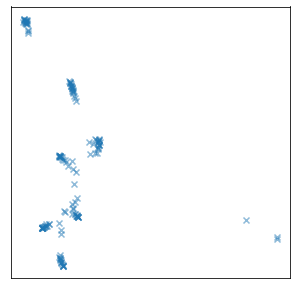

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(embeddings['umap'][is_train][:, 0], embeddings['umap'][is_train][:, 1], marker='x', alpha=0.5)
ax.set_xticks([], [])
ax.set_yticks([], [])

In [23]:
density_grid = density_model(torch.tensor(grid_inverses['umap'].reshape(-1, 64)))

In [24]:
density_ood = density_model(features_ood[mask_ood])

In [25]:
density_ood

tensor([ 52.6840,  63.8934,  -3.2661,  ..., -52.3198,   7.0554,   0.4918])

In [26]:

log_density_fit = density_model(features[mask_train]).cpu()
log_density_data = torch.cat([log_density_fit, density_ood], 0).numpy()
log_density_data = log_density_data[~util.is_outlier(log_density_data)]
vmin, vmax = log_density_data.min(), log_density_data.max()
vmin, vmax = vmin - 0.5 * (vmax - vmin), vmax + 0.5 * (vmax - vmin)

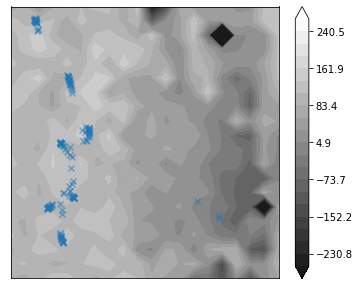

In [27]:
_, ax = plt.subplots(figsize=(6, 5))
c = ax.contourf(grids['umap'][:, :, 0], grids['umap'][:, :, 1], density_grid.numpy().reshape((20, 20)), cmap=get_greyscale_colormap(), levels=np.linspace(vmin, vmax, 20+1), extend='both', vmin=vmin, vmax=vmax)
ax.scatter(embeddings['umap'][is_train][:, 0], embeddings['umap'][is_train][:, 1], marker='x', alpha=0.5)
ax.set_xticks([], [])
ax.set_yticks([], [])

fig.colorbar(c, ax=ax)

In [28]:
is_ood = data_dict[dconst.OOD_VAL][0].is_out_of_distribution.numpy()
torch.unique(data_dict[dconst.OOD_VAL][0].y[is_ood]), torch.unique(data_dict[dconst.OOD_VAL][0].y[~is_ood])

(tensor([ 7,  8,  9, 10]), tensor([0, 1, 2, 3, 4, 5, 6]))

In [29]:
is_ood[mask_ood].shape, (~is_train).sum()

((1593,), 1593)

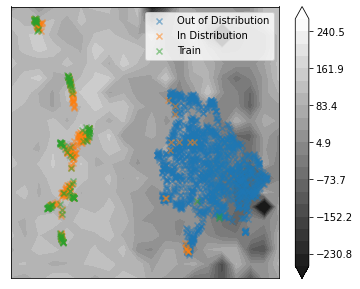

In [30]:
_, ax = plt.subplots(figsize=(6, 5))
c = ax.contourf(grids['umap'][:, :, 0], grids['umap'][:, :, 1], density_grid.numpy().reshape((20, 20)), cmap=get_greyscale_colormap(), levels=np.linspace(vmin, vmax, 20+1), extend='both', vmin=vmin, vmax=vmax)

ax.scatter(embeddings['umap'][~is_train][is_ood[mask_ood]][:, 0], embeddings['umap'][~is_train][is_ood[mask_ood]][:, 1], marker='x', alpha=0.5, label='Out of Distribution', c=econst.DISTRIBUTION_COLORS[econst.OOD_CLASS_NO_ID_CLASS_NBS])
ax.scatter(embeddings['umap'][~is_train][~is_ood[mask_ood]][:, 0], embeddings['umap'][~is_train][~is_ood[mask_ood]][:, 1], marker='x', alpha=0.5, label='In Distribution', c=econst.DISTRIBUTION_COLORS[econst.ID_CLASS_NO_OOD_CLASS_NBS])
ax.scatter(embeddings['umap'][is_train][:, 0], embeddings['umap'][is_train][:, 1], marker='x', alpha=0.5, label='Train', c=econst.COLOR_FIT)
ax.set_xticks([], [])
ax.set_yticks([], [])
ax.legend()
fig.colorbar(c, ax=ax)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Feature Log Density', ylabel='Density'>)

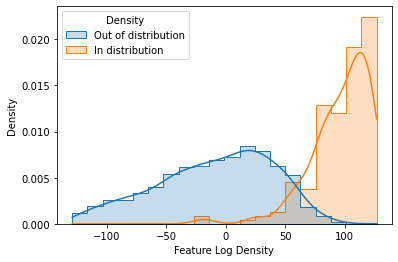

In [31]:
plot_histograms(density_ood, torch.tensor(~is_ood[mask_ood]), label_names={True: 'In distribution', False: 'Out of distribution'},
               kind='overlapping', x_label='Feature Log Density', y_label='Density')

In [32]:
features[mask_train].numpy().shape, features_ood[mask_ood].numpy().shape

((140, 64), (1593, 64))

In [33]:
density_ood.size(), is_ood[mask_ood].shape

(torch.Size([1593]), (1593,))